###### 2020-11-20 금요일

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# 08_Bidirectional LSTM

 - 자연어처리에서 **Bidirectional LSTM**을 설명하자면,
     - 사람처럼 문장을 왼쪽부터 순차적으로 읽는 방법과 (**정방향**)
     - 사람이 읽는 방법과 반대로 오른쪽부터 거꾸로 읽는 방법 (**역방향**)
 - 두가지 경우를 함께 고려하는 LSTM을 말한다

## 1. Many to Many (다 - 대 - 다)

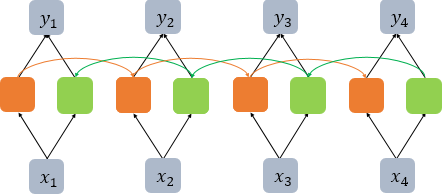

In [2]:
from PIL import Image

Image.open('./이미지/bilstm1.png')

 - 양방향 LSTM모델 중, 다대다 구조의 LSTM이다.
 - **다대다**의 경우는 주로 언어 번역기에 사용되는 방식이다

## 2. Many to One (다 - 대 - 일)

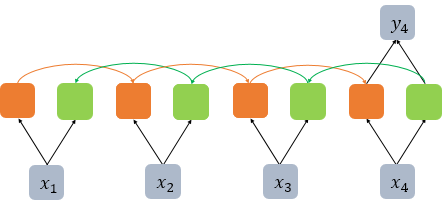

In [3]:
from PIL import Image

Image.open('./이미지/bilstm2.png')

 - 위 그림은 **다대일**의 경우이다
 - 사람의 방식으로 읽는 **정방향**방법은 **x1**, **x2**, **x3**, **x4**의 데이터를 모두 거쳐서 **y4**라는 결과를 낸다
 - 하지만 **역방향**의 방법은 **x4**만을 거쳐 **y4**라는 결과를 산출한다.
 - 이 경우 **역방향**의 방법은 **x1**, **x2**, **x3** 데이터를 전혀 고려하지 못하는 것이다
 
 ##### 역방향 방법의 이러한 약점을 고려한 방식은 다음과 같다

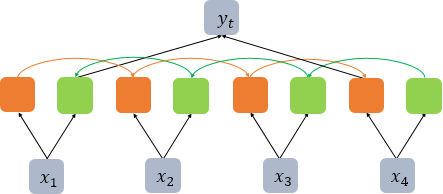

In [4]:
from PIL import Image

Image.open('./이미지/bilstm3.png')

 - 그래서 케라스에서는 양방향 LSTM을 사용하면서 `return_sequences=False`를 택할 경우에는 위의 그림과 같이 동작한다
 - 그러므로 내가 분석하고자 하는 방법에 따라서 적절히 옵션을 선택해야 할 것이다

## 3. Many-to-One LSTM 실습

 - 실습에 사용할 데이터는 **멀티캠퍼스 4차산업혁명 선도인력양성** 과정의 Final Project에서 진행한 **악플감지봇** 프로젝트의 데이터이다
 - 출처는 인스타그램, 일간베스트 등에서 내가 크롤링한 데이터의 일부이다. (약 12000개)

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split


### (1) 데이터 불러오기 & 데이터 정제

 - 댓글의 길이는 최대 400이다.
 - 데이터는 이모티콘이나 특수문자는 제거된 상태이다
 - 데이터의 라벨(Target Class)는 다음과 같다
     - 0 : 악플이 아닌 댓글
     - 1 : 명확히 악플이라 할 수 없지만, 일부 사람들에게는 불편함을 초래할 가능성이 있는 댓글
     - 2 : 특정인을 지칭하는 욕설이나 누가보아도 불쾌함을 초래하는 댓글

In [7]:
raw_df = pd.read_csv('./data/bad_comment_data.csv')

In [8]:
df = raw_df.copy()

###### 영어로 이루어져 있거나, 숫자로만 이루어진 댓글의 Label은 고려하지 않았기에 결측값으로 두었다. 제거하자

In [9]:
NaN_index = df['악플여부'].isna()
df = df[~NaN_index]

# float형의 라벨을 int형으로 변환 : 혹시몰라서~
df['악플여부'] = df['악플여부'].apply(int)

In [10]:
df.drop(['Unnamed: 0', '출처'], axis=1, inplace=True)

In [11]:
df.tail()

,댓글,악플여부
13780,기안 작품 자체가 정치색은 없고 그 시대의 사회비판 요소가 존나 강했음기안 초창기 ...,0
13781,일베에서 분탕치던 틈루새 조선족 바퀴벌레 들 총출동해서 발악하는거 봐라니들이 아무리...,0
13782,함소원씨를 그래도 좋아하는마음으로 아내의맛 애청자인데 참 안타깝네요 이모님께 존댓말...,1
13783,해마다 걷히는세금 똑같다 늘겠냐 수입과지출인데 걷히는금액 공표하고 어디다쓴느지 표기...,0
13784,일을 조금이라도 줄이시고 혜정이와 함께하는 시간을 좀 더 늘리는게 어떨까요 돈도 좋...,0


### (2) K-Fold Cross Validation을 고려하지 않은 LSTM

#### Train과 Test를 분리

In [12]:
# 고정 시드값 지정
seed = 123

# 댓글 길이 지정
comment_len = 400

In [13]:
feature = df['댓글']
label = df['악플여부']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, 
                                                    test_size   = 0.2,
                                                    random_state = vseed)

##### 텍스트 데이터 음절단위로 토큰화

In [15]:
# 음절단위로 토큰화 하기 위해 모든 데이터를 음절로 나누고 하나의 리스트에 담는다
train_token_set = sum(X_train.apply(list).tolist(), [])
test_token_set = sum(X_test.apply(list).tolist(), [])

In [16]:
# 음절에 정수인덱스를 부여하기 위해 Tokenizer 객체 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_token_set)
word_index = tokenizer.word_index

In [17]:
# 음절 단어사전의 크기
vocab_size = len(word_index)

In [18]:
# Tokenizer를 이용해 Train / Test에 정수 인덱스 부여
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [19]:
# Paddig작업 진행
train = pad_sequences(train_sequences, padding='post', maxlen=comment_len)
test = pad_sequences(test_sequences, padding='post', maxlen=comment_len)

In [20]:
print('Train :', train.shape)
print('Test :', test.shape)

Train : (10800, 400)
Test : (2700, 400)


#### SMOTE 적용

 - 라벨이 0인경우 (악플이 아닌경우)가 90% 이상을 차지하고 있다.
 - 라벨이 1과 2인 경우의 수가 작아 라벨의 불균형이 일어남
 - 그래서 SMOTE를 이용해 라벨의 불균형을 해소

In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
smote = SMOTE(random_state=seed)
train_over, y_train_over = smote.fit_sample(train, y_train)

#### Bidirectional LSTM 으로 악플분류하기

In [23]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score

In [24]:
# 음절 단어사전의 크기
vocab_size = len(word_index)
embedding_dim = 32
comment_len = 400

##### `loss` VS `metrics`
 - `loss`
     - 모델을 Train set을 이용하여 모델을 훈련시킬때 loss(손실함수)를 최소로 만들어주는 가중치들을 찾는 것을 목표로 삼는다.
     - Train Set과 관련이 있다. 훈련에 사용되는 지표라고 생각하자
 - `metrics`
     - 훈련된 모델을 Test set을 이용하여 평가할때 사용되는 지표이다.
     - Test Set과 관련이있다. Train set에 의해 훈련된 모델을 Test set을 이용하여 평가하는 지표라고 생각하자

In [25]:
# 딥러닝 모델을 compile할때 사용할 평가지표를 함수들

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [26]:
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_dim, input_length=comment_len))
model.add(LSTM(200, return_sequences=True))
model.add(Dense(3, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor= 'val_acc', mode='max', save_best_only=True)

In [28]:
history = model.fit(train_over, y_train_over, 
                    callbacks        = [es, mc],
                    epochs           = 3, 
                    batch_size       = 100, 
                    validation_split = 0.2)

Train on 21124 samples, validate on 5282 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
21124/21124 [==============================] - 1132s 54ms/sample - loss: 1.0143 - acc: 0.4498 - recall_m: 0.6185 - precision_m: 197641504.0000 - f1_m: 1.1227 - val_loss: 1.6128 - val_acc: 0.0000e+00 - val_recall_m: 1.8306 - val_precision_m: 7.2269 - val_f1_m: 2.9129
Epoch 2/3
21124/21124 [==============================] - 1155s 55ms/sample - loss: 0.9587 - acc: 0.4915 - recall_m: 0.7290 - precision_m: 1.8688 - f1_m: 1.0327 - val_loss: 1.6864 - val_acc: 0.0640 - val_recall_m: 1.8963 - val_precision_m: 8.0655 - val_f1_m: 3.0584
Epoch 3/3
21124/21124 [==============================] - 1131s 54ms/sample - loss: 0.9378 - acc: 0.5041 - recall_m: 0.7486 - precision_m: 1.7420 - f1_m: 1.0341 - val_loss: 1.7262 - val_acc: 0.0882 - val_recall_m: 1.8801 - val_precision_m: 7.5751 - val_f1_m: 3.0024


In [30]:
loaded_model = load_model('best_model.h5')

ValueError: Unknown metric function:f1_m

In [29]:
y_pred = loaded_model.predict(test)

NameError: name 'loaded_model' is not defined

In [ ]:
y_pred_df = pd.DataFrame(y_pred)
y_pred = np.array(y_pred_df.apply(lambda x : np.argmax(x), axis=1))

In [ ]:
confusion_matrix(y_pred, y_test)